# 2次元入力3クラス分類
## ■3クラス分類ロジスティック回帰モデル  
### 入力総和
3つのクラスに対応する入力総和$a_k(k=0,1,2)$を考える  
$$ a_k = w_{k0}x_0 + w_{k1}x_1 + w_{k2}　(k = 0, 1, 2) $$  
常に１をとる三番目の値 $x_2 = 1$ 仮定し、以下の式になる  
$$ a_k = w_{k0}x_0 + w_{k1}x_1 + w_{k2}x_2 = \sum_{i=0}^{D}w_{ki}x_i　(k = 0, 1, 2) $$  
  
### ソフトマックス関数  
上記入力総和をソフトマックス関数に入力。Kは分類クラス数（今回はK = 3）
$$ u = exp(a_0) + exp(a_1) + exp(a_2) = \sum_{k=0}^{K-1}exp(a_k) $$  
$$ y_k = \frac{exp(a_k)}{u} 　(k = 0, 1, 2)$$  
モデルのパラメータは、 $w_{ki}(k=0,1,2, i=0,1,2)$  
行列で表すと $ \boldsymbol{W} = 
    \begin{bmatrix}
    w_{00} & w_{01} & w_{02} \\ 
    w_{10} & w_{11} & w_{12} \\
    w_{20} & w_{21} & w_{22}
    \end{bmatrix} $  
  
### 出力  
$y_0, y_1, y_2$は、各クラスに入力xが属する確率 $P(t=[1,0,0]^T|x)、P(t=[0,1,0]^T|x)、P(t=[0,0,1]^T|x)$  
1-of-K符号化法のtは縦ベクトルで表す、全データを表すTはtの転置が縦に並んだもの  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# データ生成
np.random.seed(seed = 1)
N = 100
K = 3
T3 = np.zeros((N,3), dtype=np.uint8)
T2 = np.zeros((N,2), dtype=np.uint8)
X = np.zeros((N,2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 分布の中心
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])  # 分布の分散
Pi = np.array([0.4, 0.8, 1])
for n in range(N):
    # wk:0～1 までの一様分布乱数
    # クラス0　　wk < Pi[0]
    # クラス1　　wk >= Pi[0] && wk < Pi[1]
    # クラス2　　wk >= Pi[1] && wk < Pi[2]
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])

# 1-of-K符号化法ｓ
T2[:, 0] = T3[:, 0]
T2[:, 1] = T3[:, 1] | T3[:, 2]

In [63]:
# 3クラス用ロジスティック回帰モデル
def logistic3(x0, x1, w):
    K = 3
    w = w.reshape((3,3))
    n = len(x1)
    y = np.zeros((n, K))
    for k in range(K):
        # 𝑎𝑘=𝑤𝑘0𝑥0 + 𝑤𝑘1𝑥1 + 𝑤𝑘2
        y[:,k] = np.exp(w[k,0] * x0 + w[k,1] * x1 + w[k,2])
        
    # 𝑢=𝑒𝑥𝑝(𝑎0)+𝑒𝑥𝑝(𝑎1)+𝑒𝑥𝑝(𝑎2)
    wk=np.sum(y, axis=1) # 行ごとにSUM
    
    # 𝑦𝑘=𝑒𝑥𝑝(𝑎𝑘)/𝑢
    # yは3*3のベクトルに対して、wkは1次元配列なので行列の区別が無い、yのn行目全ての要素に対しwk[n]で割りたい場合は、
    # 一旦yを転置してそのままwkで割ってから転置を戻す
    wk = y.T / wk
    y = wk.T
    
    return y

W = np.array([1,2,3,4,5,6,7,8,9])
y = logistic3(X[:3,0], X[:3,1], W)
print(np.round(y, 3))


[[0.    0.006 0.994]
 [0.965 0.033 0.001]
 [0.925 0.07  0.005]]


(3, 3)

## ■交差エントロピー誤差 3クラス分類
1つの入力がクラス0$(t=[1,0,0]^T)$であったら、そのクラスが生成された確率は$P(t = [1,0,0]^T|x) = y_0)$  
　　　　　 クラス1だったら、生成確率は$P(t = [0,1,0]^T|x) = y_1)$  
       
どのクラスでも同じ式で表すと $ P(t|x) = y_0^{t_0}y_1^{t_1}y_2^{t_2} $  
　　　　　　　　例えばクラス1の場合 $P(t=[0,1,0]^T|x) = y_0^{0}y_1^{1}y_2^{0} = y_1$
        
全てのN個のデータが生成された確率、１つ１つの生成確率を全てかけ合わせる  
$$ P(T|X) 
   = \prod_{n=0}^{N-1}P(t_n|x_n) 
   = \prod_{n=0}^{N-1}y_0^{t_0}y_1^{t_1}y_2^{t_2} 
   = \prod_{n=0}^{N-1}\prod_{k=0}^{K-1}y_{nk}^{t_{nk}} 
$$  
  
平均交差エントロピー誤差関数  
$$
  E(W) = -\frac{1}{N} logP(T|X)
       = -\frac{1}{N} \prod_{n=0}^{N-1}P(t_n|x_n) 
       = -\frac{1}{N} \sum_{n=0}^{N-1}  \sum_{k=0}^{K-1}t_{nk}logy_{nk}
$$

In [67]:
# 交差エントロピー誤差
def cee_logistic3(w, x, t):
    # xの行数
    X_n = x.shape[0]
    # ロジスティック回帰モデルを通す
    y = logistic3(x[:, 0], x[:, 1], w)
    
    # 平均交差エントロピー誤差算出
    cee = 0
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            cee = cee - (t[n, k] * np.log(y[n, k]))
    cee = cee / X_n
    
    return cee

# test
W = np.array([1,2,3,4,5,6,7,8,9])
cee_logistic3(W, X, T3)

3.9824582404787288

## ■勾配法による解
$E(W)の各w_{ki}$に関する偏微分、途中式スキップして最終的にこうなる  
$$ \frac{∂w_{ki}}{∂E} = \frac{1}{N} \sum_{k=0}^{K-1} (y_{nk} - t_{nk}) x_{ni}$$  

In [68]:
# 交差エントロピー誤差の微分
def dcee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:, 0], x[:, 1], w)
    
    dcee = np.zeros((3,3))  # クラス数K × xの次元D+1
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            ## np.r_ : 配列同士の結合
            ### a = np.array([1, 2, 3])
            ### np.r_[a,1]
            ### > array([1, 2, 3, 1])
            ### 
            ###   np.r_[x[n, :], 1]  ← xに1次元追加 値1固定（D+1）
            dcee[k, :] = dcee[k, :] - (t[n, k] - y[n, k]) * np.r_[x[n, :], 1]
    dcee = dcee / X_n
    return dcee.reshape(-1)

# test
W = np.array([1,2,3,4,5,6,7,8,9])
dcee_logistic3(W, X, T3)

array([ 0.03778433,  0.03708109, -0.1841851 , -0.21235188, -0.44408101,
       -0.38340835,  0.17456754,  0.40699992,  0.56759346])

In [81]:
from scipy.optimize import minimize

# 最適値を見つける
def fit_logistic3(w_init, x, t):
    # CG:共役勾配法 (conjugate gradient method)
    res = minimize(cee_logistic3, w_init, args=(x, t), jac=dcee_logistic3, method="CG")

    return res.x


In [77]:
# モデル等高線2D表示
def show_contour_logistic3(w):
    xn = 30 # パラメータ分割数
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range0[0], X_range0[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    
    y = np.zeros((xn, xn, 3))
    for i in range(xn):
        wk = logistic3(xx0[:, i], xx1[:, i], w)
        for j in range(3):
            y[:, i, j] = wk[:, j]
    
    for j in range(3):
        cont = plt.contour(xx0, xx1, y[:,:,j], levels=(0.5, 0.60.9), colors=['blue', 'k'])
        cont.clabel(fmt='%.1f', fontsize=9)
    
    plt.grid(True)
    

In [78]:
# データ表示
def show_data2(x, t):
    wk, K = t.shape
    c = [[.5,  .5, .5], [1, 1, 1], [0, 0, 0]]
    for k in range(K):
        plt.plot(x[t[:, k] == 1, 0], x[t[:, k] == 1, 1], ls = 'none', mec='black', marker='o', c=c[k], alpha=0.8)
    plt.grid(True)

W = [[-3.2  -2.69  2.25]
 [-0.49  4.8  -0.69]
 [ 3.68 -2.11 -1.56]]
CEE = 0.23


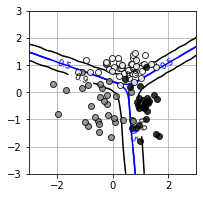

In [86]:
# main 

# W初期値
W_init = np.zeros((3,3))
# W最適値を見つける
W = fit_logistic3(W_init, X, T3)
print("W =", np.round(W.reshape((3,3)), 2))
# W最適値の交差エントロピー誤差を求める
cee = cee_logistic3(W, X, T3)
print("CEE = {0:.2f}".format(cee))

plt.figure(figsize=(3,3))
show_data2(X, T3)
show_contour_logistic3(W)
plt.show()